In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
twitter_file = "C:/Users/hilal/OneDrive/Belgeler/NLP/Tweets.csv"
df = pd.read_csv(twitter_file).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
cat_id = { "neutral": 1, "negative":0, "positive":2}

In [5]:
df['class'] = df['sentiment'].map(cat_id)

In [6]:
batch_size = 512
num_epochs = 80

In [7]:
x = df["text"].values
y = df["class"].values

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 123)
print(f"X train: {x_train.shape}, y train: {y_train.shape}\nX test: {x_test.shape}, y test: {y_test.shape}")

X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [9]:
one_hot = CountVectorizer()
x_train_one_hot = one_hot.fit_transform(x_train)
x_test_one_hot = one_hot.transform(x_test)

In [11]:
class SentimentData(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.Tensor(x.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [14]:
train_ds = SentimentData(x= x_train_one_hot, y = y_train)
test_ds = SentimentData(x_test_one_hot, y_test)

In [16]:
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [19]:
class SentimentModel(nn.Module):
    def __init__(self, num_features, num_classes, hidden = 10):
        super().__init__()
        self.linear = nn.Linear(num_features, hidden)
        self.linear2 = nn.Linear(hidden, num_classes)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [20]:
model = SentimentModel(num_features = x_train_one_hot.shape[1], num_classes = 3)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [22]:
train_losses = []
for e in range(num_epochs):
    curr_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(x_batch)
        loss = criterion(y_pred_log, y_batch.long())
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")

Epoch 0, Loss: 30.179739356040955
Epoch 1, Loss: 28.767434239387512
Epoch 2, Loss: 27.18718409538269
Epoch 3, Loss: 25.38810557126999
Epoch 4, Loss: 23.527426600456238
Epoch 5, Loss: 21.694852650165558
Epoch 6, Loss: 19.970998466014862
Epoch 7, Loss: 18.373821079730988
Epoch 8, Loss: 16.95216178894043
Epoch 9, Loss: 15.669901847839355
Epoch 10, Loss: 14.552672505378723
Epoch 11, Loss: 13.544851928949356
Epoch 12, Loss: 12.667046785354614
Epoch 13, Loss: 11.879597932100296
Epoch 14, Loss: 11.185107588768005
Epoch 15, Loss: 10.552547186613083
Epoch 16, Loss: 9.981992036104202
Epoch 17, Loss: 9.472773849964142
Epoch 18, Loss: 8.99655133485794
Epoch 19, Loss: 8.571265935897827
Epoch 20, Loss: 8.176711082458496
Epoch 21, Loss: 7.8172594755887985
Epoch 22, Loss: 7.479047551751137
Epoch 23, Loss: 7.162030071020126
Epoch 24, Loss: 6.869125202298164
Epoch 25, Loss: 6.604673683643341
Epoch 26, Loss: 6.342753067612648
Epoch 27, Loss: 6.1122491508722305
Epoch 28, Loss: 5.8847049325704575
Epoch 29,

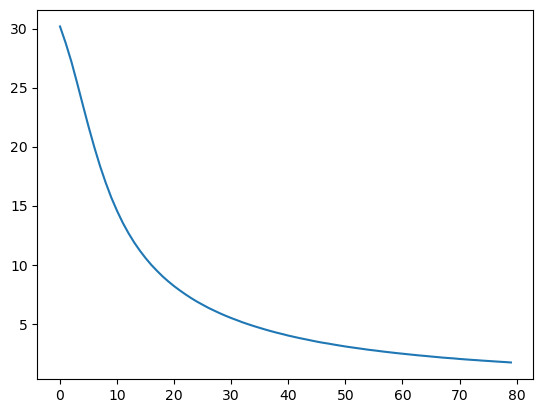

In [25]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()

In [26]:
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_test_pred_log = model(x_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)

In [27]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [28]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 63.5%.'

In [29]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 41.0 %


<Axes: >

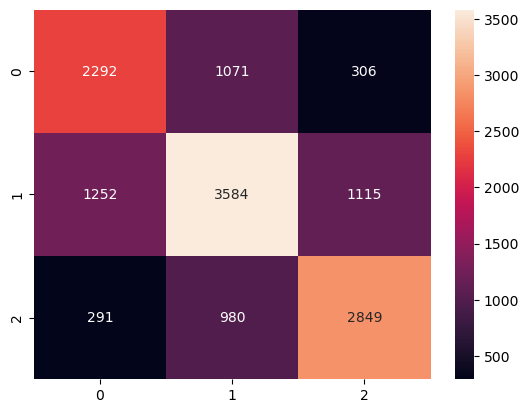

In [30]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")